# Deepracer Dev Log
[_Congrats Richard U., you've managed to nerd snipe me._](https://xkcd.com/356/)

Hi this is a dev log for the _redacted_ 2024 DeepRacer competition.

DeepRacer is an AWS platform used to introduce developers to Reinforcement Learning.
Basically Reinforcement learning is automated supervised learning in the sense that supervised training data is automatically generated from and fed back into the training process.
In the case of DeepRacer, we are training a neural network to race a car through an arbitrary track using video image data.
This is done by using a "reward function" to "grade" the successive "states" that occur due to the neural network's actions.

For example in the case of DeepRacer, we are given a "params" dictionary object that contains information about the car's current state.
This information includes data about the position, speed, and orientation of the car; along with information about its position relative to the track (is it on or off the track).
As the goal of this project is to get the car to race through the track in the least amount of time possible without going off track or crashing;
our reward function should reward states that are associated with fast race completion times higher than slower race times or crashes.

Information about the properties supplied by the "params" dictionary object can be found [here](https://docs.aws.amazon.com/deepracer/latest/developerguide/deepracer-reward-function-input.html)
Sample simple reward functions can be found [here](https://docs.aws.amazon.com/deepracer/latest/developerguide/deepracer-reward-function-examples.html)

Other useful information that I have located is that:
 - We are using a single camera car (the original deep racer)
 - The camera pulls images at a rate of 15 frames per second
 - we can use a restricted set of python libraries (math, random, numpy, scipy, shapely)

## Initial thoughts
Based off of prior experience with racing go karts, the neural net should probably try to get the car to drive racing lines.

## Project Plan and Tasks:
    - [x] read through documentation

## Open questions:
    - How do we know if the car has flipped in the simulator? (params.is_crashed?)
    - How can we detect skidding in the simulator?

## Proximal Policy Optimization (PPO) Notes

PPO was created by OpenAi in 2017 and appears to be the current standard for Reinforcement Learning.
Appears to be an incremental improvement on the standard Gradient Descent method but with "clipping".
Where "clipping" refers to the limiting of policy changes between updates to prevent performance collapse.

Resources:
 - https://huggingface.co/learn/deep-rl-course/unit8/introduction 
 - Arxiv PDF: https://arxiv.org/abs/1707.06347
 - Open ai docs:
    - https://spinningup.openai.com/en/latest/algorithms/ppo.html 
    - https://openai.com/index/openai-baselines-ppo/ 
 - wiki: https://en.wikipedia.org/wiki/Proximal_policy_optimization
 - Simulator notes:
    - https://openai.com/index/roboschool/ (defunct) see https://github.com/Farama-Foundation/Gymnasium and https://farama.org/projects 
    - joint simulation
        - mujoco
            - https://gymnasium.farama.org/environments/mujoco/ 
            - https://github.com/google-deepmind/mujoco 
            - https://mujoco.readthedocs.io/en/stable/overview.html



## Deepracer notes

Utilities to process DeepRacer logs: https://github.com/aws-deepracer-community/deepracer-utils 
 - useful for extracting route information
Blog on how to train with Racing Lines:
 - https://mickqg.github.io/DeepracerBlog/ 
 - https://mickqg.github.io/DeepracerBlog/part2.html
 - https://github.com/MickQG/deepracer-analysis/blob/master/README.md

AWS stuff:
 - https://github.com/aws-solutions-library-samples/guidance-for-training-an-aws-deepracer-model-using-amazon-sagemaker 
 - https://docs.aws.amazon.com/deepracer/latest/student-userguide/reward-function.html
 - https://github.com/matrousseau/AWS-Deepracer-Optimal-Path-Generator 


## Racing Lines:
    - https://www.reddit.com/r/coolguides/comments/vw0k49/ideal_racing_lines/ 
    

## Shapely
 - https://shapely.readthedocs.io/en/stable/manual.html 
 - https://pypi.org/project/shapely/ 
 - https://github.com/shapely/shapely
 
Spatial analysis library for python, useful for route manipulation.
Additional work in [shapelyExp.ipynb](shapelyExp.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
import json 
import math
import random
import numpy
import scipy
from shapely.geometry import LineString, Point
from shapely.ops import nearest_points
import shapely


params = None 
with open("./params.json", 'r') as f:
    params = json.load(f)
print(params)

{'all_wheels_on_track': True, 'x': 3.0, 'y': 3.0, 'closest_objects': [3, 4], 'closest_waypoints': [0, 1], 'distance_from_center': 0.1, 'is_crashed': False, 'is_left_of_center': True, 'is_offtrack': False, 'is_reversed': False, 'heading': 0.1, 'objects_distance': [0.3, 0.1], 'objects_heading': [0.1, 0.2], 'objects_left_of_center': [True, False], 'objects_location': [], 'objects_speed': [3.0, 5.0], 'progress': 0.1, 'speed': 0.1, 'steering_angle': 0, 'steps': 0, 'track_length': 3, 'track_width': 0.1, 'waypoints': [[0, 0], [0, 2]]}


#Reward function component testing

In [2]:
import reward_function

al = [0,1,2,3,4,5]
assert [1, 2, 3, 4, 5, 0, 1] == reward_function.spliceWithLoop(al, 1, 8)
params['speed'] = 5
params['heading'] = 90
params["steering_angle"] = 0
params['x'] = 10
params['y'] = 0
reward_function.get_projected_car_path(params).xy

(array('d', [10.0, 10.0]), array('d', [0.0, 0.3333333333333333]))

In [3]:
from deepracer.logs import (AnalysisUtils, DeepRacerLog)

drl = DeepRacerLog(model_folder='./deepracerlogs/joes-test-model-42-training_job_ngORYSXKStmsCby370Xdtw_logs')
drl.load_training_trace()
training_df = drl.dataframe()

TypeError: expected str, bytes or os.PathLike object, not NoneType

(0.19649399364129694, 0.9805050282700717)


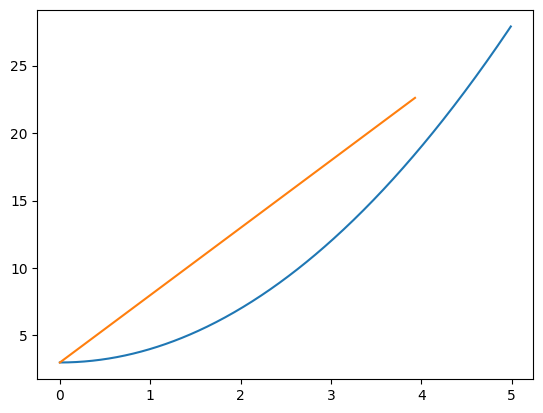

In [11]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Example coordinates for a sine curve
x = np.arange(0, 5, 0.01)
y = x**2 + 3
line = LineString(zip(x, y))

vector = reward_function.get_vector(line)

print(vector)
plt.plot(x, y)
c = 20
plt.plot([0, vector[0]*c], [3, 3+vector[1]*c])
plt.show()

(-0.4061384660534476, 0.9138115486202572)


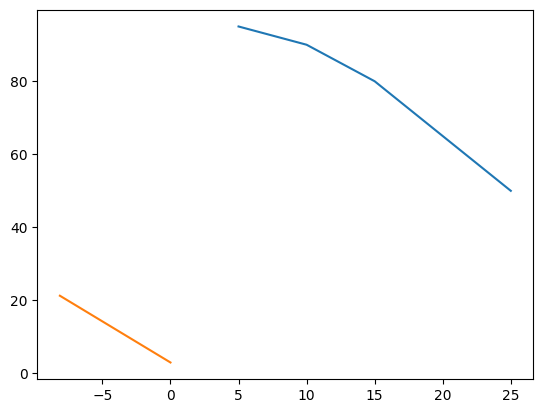

In [13]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Example coordinates for a sine curve
x = [25, 20, 15, 10, 5]
y = [50, 65, 80, 90, 95]
line = LineString(zip(x, y))

vector = reward_function.get_vector(line)

print(vector)
plt.plot(x, y)
c = 20
plt.plot([0, vector[0]*c], [3, 3+vector[1]*c])
plt.show()

(0.01960407493444558, -0.9998078216567245)


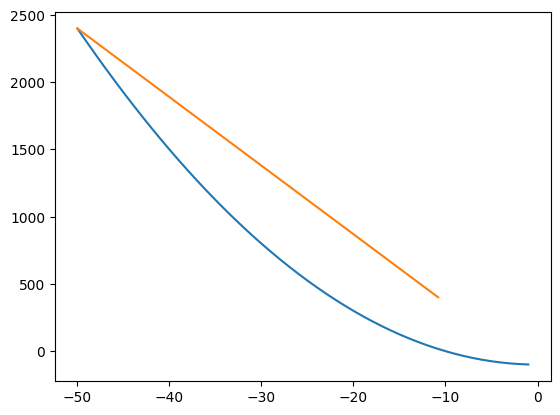

In [18]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Example coordinates for a sine curve
x = np.arange(-50, 0, 1)
y = x**2 - 100
line = LineString(zip(x, y))

vector = reward_function.get_vector(line)

print(vector)
plt.plot(x, y)
c = 2000
plt.plot([x[0], x[0] + vector[0]*c], [y[0], y[0]+vector[1]*c])
plt.show()

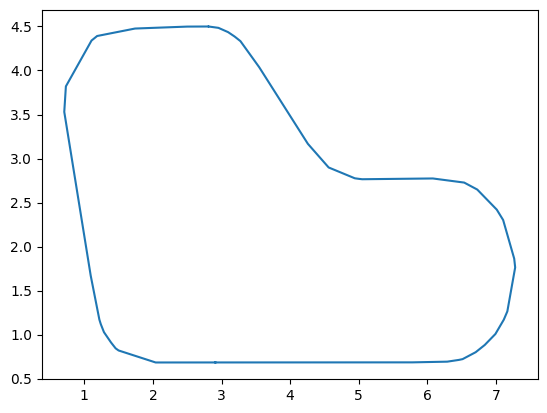

In [36]:
import matplotlib.pyplot as plt
from shapely.geometry import LineString
import numpy as np

# Example coordinates for a sine curve
wx = [2.909995283569139, 3.3199952311658905, 3.41999521838461, 3.6300023417267235, 4.189995119968753, 4.500002230529587, 4.549995073956144, 5.320002125723089, 5.420002112941809, 5.7800020669292005, 6.289747858140073, 6.460906484698166, 6.5136980596947165, 6.704287871536597, 6.836281775656231, 6.991663362669656, 7.1142074641408275, 7.165830682349035, 7.280019741788613, 7.272892208655982, 7.265960701310593, 7.1045747673751585, 7.011749008840918, 6.727273712845888, 6.536921216759571, 6.079802178702642, 5.919813651266964, 5.719827991972368, 5.670000926947205, 5.200034627604903, 5.049876033335467, 5.002030872389276, 4.942709994269048, 4.561340171137485, 4.258533108743229, 4.092728535429521, 4.001121969780925, 3.774000078716213, 3.6823935130676184, 3.5490587458571623, 3.2758532950668884, 3.1911463583891155, 3.0954945192403103, 2.9549738926202442, 2.8089822299540046, 2.8110045575773057, 2.5003276964136627, 2.249377566090162, 1.990177178741659, 1.7395172672798365, 1.1871156114665855, 1.1054389398706574, 0.7316196323127645, 0.7080468873794841, 0.8747319412102282, 0.8863119620897287, 0.9180990438541362, 0.9380374746317692, 1.0212099341560652, 1.043063552869095, 1.0936256517149223, 1.219724413480236, 1.2404620134668318, 1.286611404297767, 1.3195344250237366, 1.3897426105955222, 1.4563853812178036, 1.4996428710531535, 2.0400025449490777, 2.7500024542019887, 2.909995283569139]
wy = [0.6831924746239328, 0.6833390533713652, 0.6833748042853732, 0.6834498837610459, 0.6836500863232341, 0.6837609167129147, 0.6837787896136626, 0.6840540742077795, 0.6840898251217875, 0.684218528412216, 0.6921400142174, 0.7123063542781353, 0.7210294115664316, 0.799598672280553, 0.8817004790362547, 1.0062653214908401, 1.1693225137564909, 1.263426756737598, 1.7628308313393968, 1.8132370038722583, 1.8622568749360433, 2.3014874894475916, 2.419260292916218, 2.6474924751765463, 2.7266447610626687, 2.773360773339069, 2.772005974951175, 2.7703124769663074, 2.7698905365406308, 2.765910816276192, 2.7646392587170006, 2.768980714618128, 2.775327848322301, 2.898322513024676, 3.166955220685885, 3.3703748558215287, 3.482763638518189, 3.761411273431655, 3.8738000561283137, 4.037383660336441, 4.333295323360169, 4.385684825652305, 4.435922305057415, 4.484413606024224, 4.500038654567632, 4.499832029419236, 4.498718163592657, 4.491428972830993, 4.483900142037221, 4.476619381080485, 4.391792930201858, 4.3402307341807065, 3.819658838269335, 3.5295953182618844, 2.7251244177375193, 2.6692358445815714, 2.5158220758940644, 2.4195933679559642, 2.0181787127447155, 1.912706746772055, 1.6686792454688633, 1.169889412099395, 1.1182110370035536, 1.0270193376917442, 0.9895904728963364, 0.9097735962139227, 0.8435308547287804, 0.8193608401945228, 0.6828814442283201, 0.6831352757177762, 0.6831924746239328]

plt.plot(wx, wy)
plt.show()

In [37]:
waypoints = list(zip(wx, wy))
print(waypoints)

[(2.909995283569139, 0.6831924746239328), (3.3199952311658905, 0.6833390533713652), (3.41999521838461, 0.6833748042853732), (3.6300023417267235, 0.6834498837610459), (4.189995119968753, 0.6836500863232341), (4.500002230529587, 0.6837609167129147), (4.549995073956144, 0.6837787896136626), (5.320002125723089, 0.6840540742077795), (5.420002112941809, 0.6840898251217875), (5.7800020669292005, 0.684218528412216), (6.289747858140073, 0.6921400142174), (6.460906484698166, 0.7123063542781353), (6.5136980596947165, 0.7210294115664316), (6.704287871536597, 0.799598672280553), (6.836281775656231, 0.8817004790362547), (6.991663362669656, 1.0062653214908401), (7.1142074641408275, 1.1693225137564909), (7.165830682349035, 1.263426756737598), (7.280019741788613, 1.7628308313393968), (7.272892208655982, 1.8132370038722583), (7.265960701310593, 1.8622568749360433), (7.1045747673751585, 2.3014874894475916), (7.011749008840918, 2.419260292916218), (6.727273712845888, 2.6474924751765463), (6.53692121675957

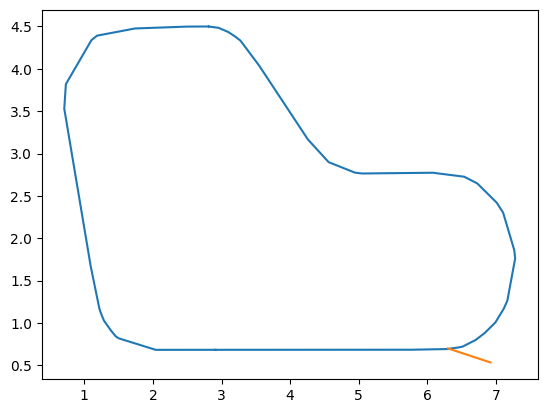

In [48]:
params = {
    "waypoints": waypoints,
    "speed": 9,
    "heading": 5,
    "steering_angle": -20,
    'x': 6.3,
    'y': 0.7,
}

path = reward_function.get_projected_car_path(params, 1/14)

px, py = path.xy

plt.plot(wx, wy)
plt.plot(px, py)
plt.show()

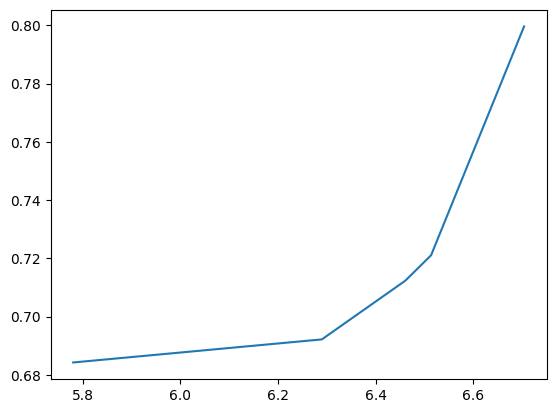

In [59]:
params = {
    "waypoints": waypoints,
    "closest_waypoints": [9, 10],
    "speed": 0.2,
    "heading": 5,
    "steering_angle": -20,
    'x': 6.3,
    'y': 0.7,
    "track_width": 0.2,
    'track_length': 14
}

track = reward_function.get_track_section(params, 5)
tx, ty = track[1].xy

plt.plot(tx, ty)
plt.show()


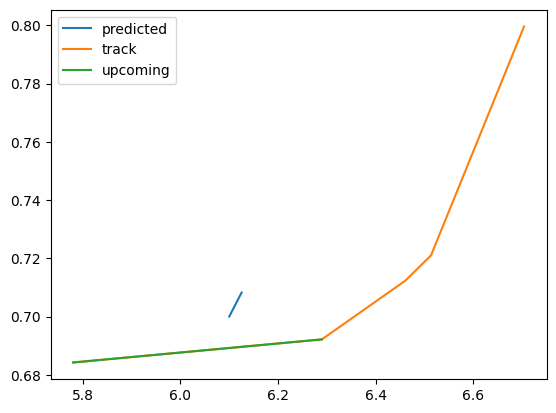

[(6.1, 0.7), (6.1253615071012035, 0.7082404531833318)]


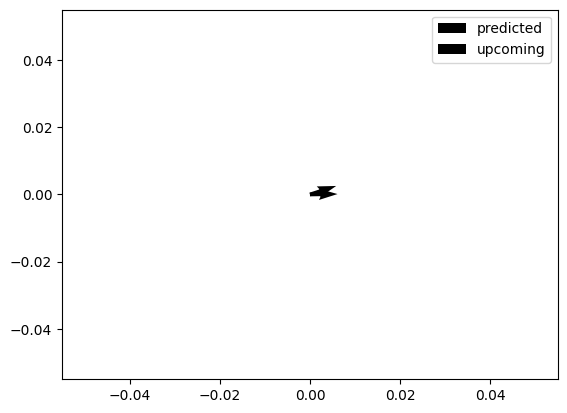

In [74]:
params = {
    "waypoints": waypoints,
    "closest_waypoints": [9, 10],
    "speed": 0.2,
    "heading": 0,
    "steering_angle": 18,
    'x': 6.1,
    'y': 0.7,
    "track_width": 0.2,
    'track_length': 14
}

delta = 2/15
predicted_car_path = reward_function.get_projected_car_path(params, delta)
upcomingCount = reward_function.get_expected_future_waypoint_advancement(params, delta)
upcomingWayPointsLeft, upcomingCenterLine, upcomingWayPointsRight = reward_function.get_track_section(params, upcomingCount)
# score = dot product of predicted_car_path unit vector and upcomingCenterLine unit vector
vector_predicted = reward_function.get_vector(predicted_car_path)
vector_upcoming = reward_function.get_vector(upcomingCenterLine)
score = reward_function.dot_product(vector_predicted, vector_upcoming)

px, py = predicted_car_path.xy
ux, uy = upcomingCenterLine.xy

# plt.plot(wx, wy)
plt.plot(px, py, label='predicted')
plt.plot(tx, ty, label='track')
plt.plot(ux, uy, label='upcoming')
plt.legend()
plt.show()
print(list(zip(px, py)))

vpx, vpy = vector_predicted
vux, vuy = vector_upcoming
plt.quiver(vpx, vpy, label='predicted')
plt.quiver(vux, vuy, label='upcoming')
plt.legend()
plt.show()

In [28]:
from numpy import load 
import io 

wp = load('./AWS_track.npy')

wp2019 = load('./reInvent2019_track_cw.npy')
wp2019

array([[-4.01392906e+00, -2.74160509e-01, -3.48346571e+00,
        -2.80842153e-01, -4.54421802e+00, -2.67466634e-01],
       [-4.02197754e+00, -1.44409895e-01, -3.49201989e+00,
        -1.51123896e-01, -4.55193520e+00, -1.37695894e-01],
       [-4.01064452e+00, -1.49048270e-02, -3.48111375e+00,
        -2.15821808e-02, -4.54036639e+00, -8.21167572e-03],
       [-3.99547994e+00,  1.58384357e-01, -3.47387099e+00,
         6.44463077e-02, -4.51708889e+00,  2.52322406e-01],
       [-3.91469204e+00,  4.51342836e-01, -3.42459798e+00,
         2.49579996e-01, -4.40478611e+00,  6.53105676e-01],
       [-3.76599658e+00,  7.15934336e-01, -3.34861112e+00,
         3.89300704e-01, -4.18338203e+00,  1.04256797e+00],
       [-3.54482853e+00,  9.23942700e-01, -3.24614310e+00,
         4.86122400e-01, -3.84351397e+00,  1.36176300e+00],
       [-3.27043307e+00,  1.05400518e+00, -3.10593510e+00,
         5.50179303e-01, -3.43493104e+00,  1.55783105e+00],
       [-2.97171950e+00,  1.11100248e+00, -2.919